Importing libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import os
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
new_lfc = pd.read_csv('~/Documents/repos/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
new_lfc.head()

,Rv_ID,129s1.SvImJ_vs_C57BL.6J,129s1.SvImJ_vs_mbio_H37Rv,A.J_vs_129s1.SvImJ,A.J_vs_C57BL.6J,A.J_vs_mbio_H37Rv,C57BL.6J_vs_129s1.SvImJ,C57BL.6J_vs_A.J,C57BL.6J_vs_C57BL.6J,C57BL.6J_vs_mbio_H37Rv,...,zhang_DETA-NO_pH_7.0_vs_zhang_pH_7.0_no_NO_control,zhang_Fe_1.5mM_vs_zhang_Fe_450uM,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45,zhang_wt_mouse_d10_vs_zhang_input_library,zhang_wt_mouse_d45_vs_zhang_input_library,Functional_Category
0,Rv0001,0.00,-0.18,0.00,0.00,-0.18,0.00,0.00,0.0,-0.18,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,0.00,-0.07,0.00,0.00,-0.07,0.00,0.00,0.0,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
2,Rv0003,1.54,-1.86,-0.99,0.56,-2.85,-1.54,-0.56,0.0,-3.41,...,-0.31,1.09,-2.13,0.51,0.41,1.30,-0.49,-1.26,-2.25,information pathways
3,Rv0005,-0.56,-0.58,-0.08,-0.64,-0.65,0.56,0.64,0.0,-0.02,...,-0.89,-2.36,-1.89,2.90,2.20,-4.05,0.30,0.69,-3.55,information pathways
4,Rv0006,0.78,2.77,-0.55,0.23,2.22,-0.78,-0.23,0.0,1.99,...,0.23,-1.51,4.80,-2.90,-2.05,-2.93,0.87,3.70,3.67,information pathways


Creating a Y Vector

In [34]:
y_list = []
i = 0
for gene in new_lfc.Functional_Category:
    if gene == "PE/PPE":
        y_list.append(1)
    else:
        y_list.append(0)
    i+=1

y = np.array(y_list)
y[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

Creating the x vector as a 2D array

In [35]:
raw_x= new_lfc.drop(["Rv_ID", "Functional_Category"], axis = 1)
X = raw_x.to_numpy()
X

array([[ 0.  , -0.18,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.07,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.54, -1.86, -0.99, ..., -0.49, -1.26, -2.25],
       ...,
       [ 0.41, -1.54, -1.67, ..., -0.93, -2.15, -2.06],
       [-1.68, -2.47,  1.42, ...,  1.6 , -3.8 , -3.8 ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [38]:
#Step 1: Create Logistic REgression Classifier.
C_temp = 1
#clf = XGBClassifier()
clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_temp, random_state=42)
#Step 2: Split samples into training and test sets using STratifiedKFOld
n_splits_Temp = 5
n_classes = 2
skf = StratifiedKFold(n_splits=n_splits_Temp, shuffle=True, random_state=42)

In [10]:
confusion = np.zeros((n_classes, n_classes))
#Step 3: ITerate thru each training/test set.

log_loss_var = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    X_train, y_train = SMOTE().fit_resample(X_train, y_train) 
    #Step 4: Fit the logistic regression to the training data. 
    clf.fit(X_train, y_train)
    #Step 5: Predict the values of the testing data. 
    y_hat = clf.predict(X_test)
    confusion += confusion_matrix(y_test, y_hat)
    y_pred = clf.predict_proba(X_test)
    log_loss_var.append(log_loss(y_test, y_pred))
average_logloss = sum(log_loss_var)/len(log_loss_var)
    
confusion = normalize(confusion, axis=1, norm='l1')

log_loss_var


NameError: name 'n_classes' is not defined

In [41]:
average_logloss

0.5276504922913097

In [8]:
confusion

array([[0.98594595, 0.01405405],
       [0.62962963, 0.37037037]])

In [9]:
clf.classes_

array([0, 1])

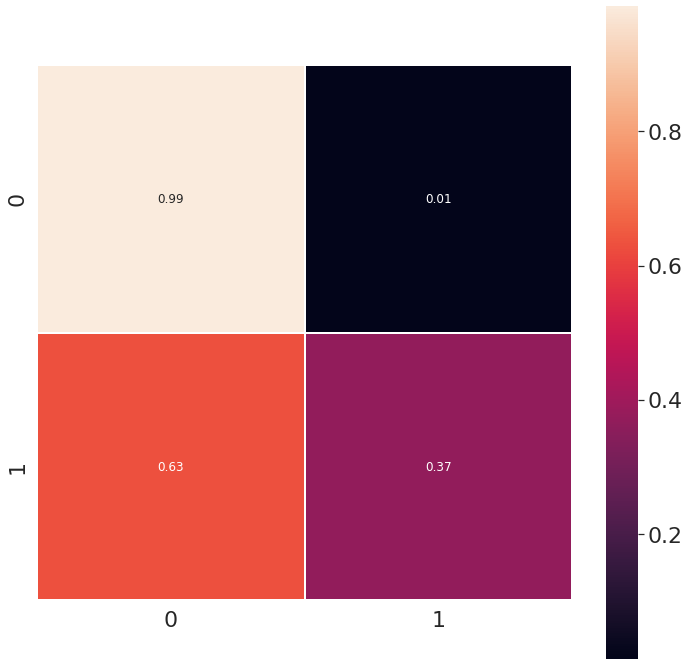

In [12]:
col_names = list(clf.classes_)
df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

plt.figure(figsize=(12,12))
rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
sns.set(rc=rc)
heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":12})
filename = "PE_PPE,1.png"
plt.savefig(filename)

In [14]:
print(log_loss_var)

[0.21747839034034094, 0.20802537252752376, 0.21649470144004784, 0.1524316223680568, 0.18154488428882595]


In [13]:
plt.savefig("test.png")

<Figure size 432x288 with 0 Axes>

Predicting Essentiality for Cell Wall 

In [4]:
def accuracy_matrix(classname, C_temp, shuffle):
    #Creating the y variable. 
    y_list = []
    i = 0
    for gene in new_lfc.Functional_Category:
        if gene == classname:
            y_list.append(1)
        else:
            y_list.append(0)
        i+=1
    y = np.array(y_list)
    
    #Shuffling the y matrix. 
    if shuffle == True:
            random.shuffle(y)
            
    #Creating the x variable.
    raw_x= new_lfc.drop(["Rv_ID", "Functional_Category"], axis = 1)
    X = raw_x.to_numpy()

    #Step 1: Create Logistic REgression Classifier.
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_temp, random_state=42)
    #Step 2: Split samples into training and test sets using STratifiedKFOld
    n_splits_Temp = 5
    n_classes = 2
    skf = StratifiedKFold(n_splits=n_splits_Temp, shuffle=True, random_state=42)
    confusion = np.zeros((n_classes, n_classes))
    log_loss_var = []
    #Step 3: ITerate thru each training/test set.
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        #Step 4: Fit the logistic regression to the training data. 
        clf.fit(X_train, y_train)
        #clf = XGBClassifier()
        clf.fit(X_train, y_train)
        #Step 5: Predict the values of the testing data. 
        y_hat = clf.predict(X_test)
        confusion += confusion_matrix(y_test, y_hat)
        #Create a list of all the accuracy matrixes.
        y_pred = clf.predict_proba(X_test)
        log_loss_var.append(log_loss(y_test, y_pred))
    average_logloss = sum(log_loss_var)/len(log_loss_var)

    confusion = normalize(confusion, axis=1, norm='l1')

    col_names = list(clf.classes_)
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    #plt.figure(figsize=(12,12))
    
    #rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    #sns.set(rc=rc)
    #heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":12})
    #if "/" in classname:
        #classname = classname.split("/")
    #if shuffle == True:
        #filename = str(classname)+","+str(C_temp)+"_shuffle"+".png"
    #elif shuffle == False:
        #filename = str(classname)+","+str(C_temp)+"_real"+".png"
    #plt.savefig(filename)
    return average_logloss


<AxesSubplot:>

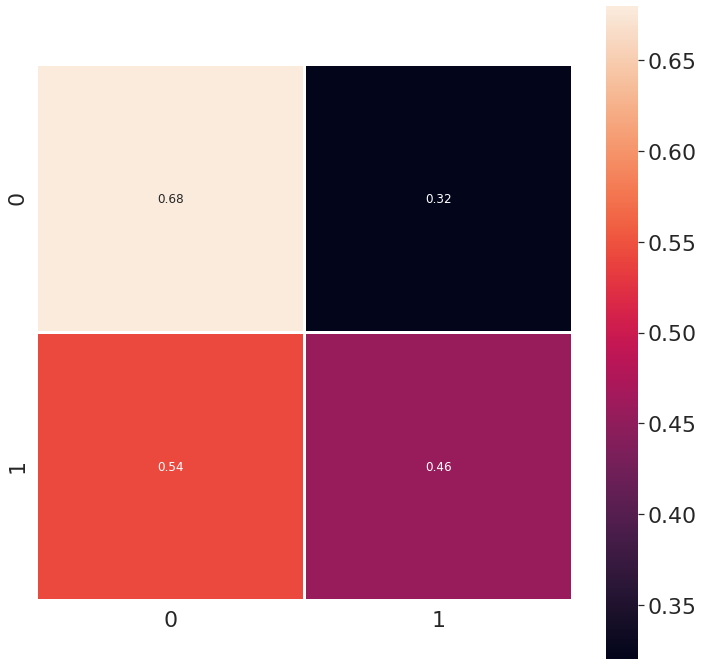

In [22]:
accuracy_matrix("intermediary metabolism and respiration", 0.01)

Creating a matrix with combination of classifier and C values

In [5]:
Fxnal_Categories = list(new_lfc.Functional_Category.unique())
C_values =[0.001, 0.01, 0.1, 1]
Bool = [True, False]

Possible_Matrices = []
for Category in Fxnal_Categories:
    for C in C_values:
        for val in Bool:
            Combo =[]
            Combo.extend([Category,C,val])
            Possible_Matrices.append(Combo)

print(Possible_Matrices)

[['information pathways', 0.001, True], ['information pathways', 0.001, False], ['information pathways', 0.01, True], ['information pathways', 0.01, False], ['information pathways', 0.1, True], ['information pathways', 0.1, False], ['information pathways', 1, True], ['information pathways', 1, False], ['cell wall and cell processes', 0.001, True], ['cell wall and cell processes', 0.001, False], ['cell wall and cell processes', 0.01, True], ['cell wall and cell processes', 0.01, False], ['cell wall and cell processes', 0.1, True], ['cell wall and cell processes', 0.1, False], ['cell wall and cell processes', 1, True], ['cell wall and cell processes', 1, False], ['intermediary metabolism and respiration', 0.001, True], ['intermediary metabolism and respiration', 0.001, False], ['intermediary metabolism and respiration', 0.01, True], ['intermediary metabolism and respiration', 0.01, False], ['intermediary metabolism and respiration', 0.1, True], ['intermediary metabolism and respiration',

In [6]:
ReallogLoss = []
Shufflelogloss = []

for matrix in Possible_Matrices:
    average_logloss = accuracy_matrix(matrix[0], matrix[1], matrix[2])
    if matrix[2] == False:
        ReallogLoss.append(average_logloss)
    elif matrix[2] == True:
        Shufflelogloss.append(average_logloss)


Creating a Data Frame of LogLoss Values for each C 

In [7]:
Categories = []
C_parameters = []
for matrix in Possible_Matrices:
    if matrix[2] == True:
        Categories.append(matrix[0])
        C_parameters.append(matrix[1])
data= {'c':C_parameters,'Real_Data':ReallogLoss, 'Shuffle_Data':Shufflelogloss} #Creating a data frame with all the C values.
df_LogLoss = pd.DataFrame(data,index = [Categories])
df_COOO1 = df_LogLoss[df_LogLoss.c == 0.001] #Making a data frame for each c value.
df_COO1 = df_LogLoss[df_LogLoss.c == 0.01]
df_CO1 = df_LogLoss[df_LogLoss.c == 0.1]
df_C1 = df_LogLoss[df_LogLoss.c == 1]
df_list = [df_COOO1, df_COO1, df_CO1, df_C1]
df_LogLoss

,c,Real_Data,Shuffle_Data
information pathways,0.001,0.693147,0.693147
information pathways,0.010,0.637329,0.639399
information pathways,0.100,0.616617,0.673231
information pathways,1.000,0.638193,0.725515
cell wall and cell processes,0.001,0.693147,0.693147
cell wall and cell processes,0.010,0.681504,0.690413
cell wall and cell processes,0.100,0.680335,0.714988
cell wall and cell processes,1.000,0.705641,0.733085
intermediary metabolism and respiration,0.001,0.693147,0.693147
intermediary metabolism and respiration,0.010,0.662490,0.687683


In [8]:
df_CO1

,c,Real_Data,Shuffle_Data
information pathways,0.1,0.616617,0.673231
cell wall and cell processes,0.1,0.680335,0.714988
intermediary metabolism and respiration,0.1,0.680980,0.715375
regulatory proteins,0.1,0.651821,0.698636
"virulence, detoxification, adaptation",0.1,0.646879,0.675755
insertion seqs and phages,0.1,0.425573,0.626123
lipid metabolism,0.1,0.668504,0.697464
PE/PPE,0.1,0.490297,0.670006


In [9]:
def logloss_scatter(df):
    plt.scatter(df.Real_Data, df.Shuffle_Data)

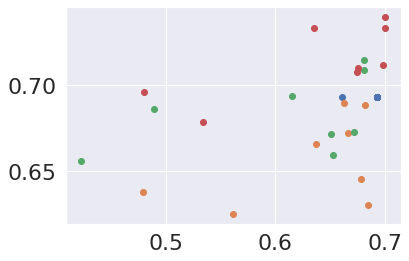

In [25]:
for df in df_list:
    logloss_scatter(df)

In [21]:
df_COOO1

,c,Real_Data,Shuffle_Data
information pathways,0.001,0.693147,0.693147
cell wall and cell processes,0.001,0.693147,0.693147
intermediary metabolism and respiration,0.001,0.693147,0.693147
regulatory proteins,0.001,0.693147,0.693147
"virulence, detoxification, adaptation",0.001,0.693147,0.693147
insertion seqs and phages,0.001,0.660548,0.693147
lipid metabolism,0.001,0.693147,0.693147
PE/PPE,0.001,0.693147,0.693147


In [32]:
print(xyline)

[0.3        0.30505051 0.31010101 0.31515152 0.32020202 0.32525253
 0.33030303 0.33535354 0.34040404 0.34545455 0.35050505 0.35555556
 0.36060606 0.36565657 0.37070707 0.37575758 0.38080808 0.38585859
 0.39090909 0.3959596  0.4010101  0.40606061 0.41111111 0.41616162
 0.42121212 0.42626263 0.43131313 0.43636364 0.44141414 0.44646465
 0.45151515 0.45656566 0.46161616 0.46666667 0.47171717 0.47676768
 0.48181818 0.48686869 0.49191919 0.4969697  0.5020202  0.50707071
 0.51212121 0.51717172 0.52222222 0.52727273 0.53232323 0.53737374
 0.54242424 0.54747475 0.55252525 0.55757576 0.56262626 0.56767677
 0.57272727 0.57777778 0.58282828 0.58787879 0.59292929 0.5979798
 0.6030303  0.60808081 0.61313131 0.61818182 0.62323232 0.62828283
 0.63333333 0.63838384 0.64343434 0.64848485 0.65353535 0.65858586
 0.66363636 0.66868687 0.67373737 0.67878788 0.68383838 0.68888889
 0.69393939 0.6989899  0.7040404  0.70909091 0.71414141 0.71919192
 0.72424242 0.72929293 0.73434343 0.73939394 0.74444444 0.74949

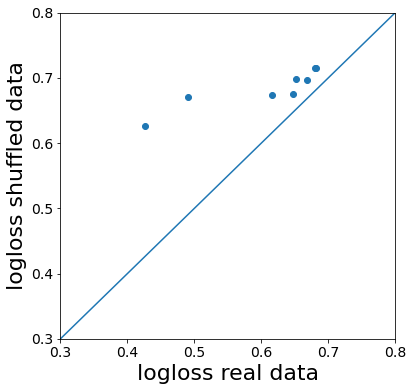

In [10]:
plt.figure(figsize = (6,6))
plt.scatter(df_CO1.Real_Data, df_CO1.Shuffle_Data)
plt.xlim(0.3,0.8)
plt.ylim(0.3,0.8)
xyline = np.linspace(0.3,0.8,20)
plt.plot(xyline, xyline)
plt.xlabel('logloss real data', fontsize = 22)
plt.ylabel('logloss shuffled data', fontsize = 22)
xt = plt.xticks(fontsize = 14)
yt = plt.yticks(fontsize = 14)
plt.errorbar(x, y, yerr=e, fmt='o')

### 